# Libraries

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
from scipy.optimize import curve_fit
from scipy.linalg import svd
from scipy.stats import trim_mean
import addcopyfighandler
import statistics
import math
import time
from tqdm import trange
from matplotlib import cm
import sklearn
from sklearn.cluster import KMeans
import colorsys
from datetime import date
import pickle

# Initialize

In [2]:
integer_TI = True                   #should the integer of the null point be used as the center
nondimensional_option = False       #This influences if scale the T2 and T1 values relative to the TE and TI values

In [3]:
######All Fixed parameters for code
#Parameters held constant
c1 = 0.2
c2 = 0.8 #0.5
T21 = 40
T22 = 100
T11 = 600
T12 = 1200

true_params = np.array([T11, T12, c1, c2, T21, T22])

#Preparing TI array to loop through
TI1star = np.log(2)*T11
TI2star = np.log(2)*T12

nTE = 64
dTE = 8
TE_series = np.linspace(dTE, dTE*nTE, nTE) #ms units
assert(TE_series[-1] == dTE*nTE)

SNR_value = 100

#Information determing TI range
genResolution = 5 #30
nullResolution = 0.5
nullRadius = 20  #20

standard_array = np.arange(-nullRadius,nullRadius+0.01,nullResolution)
if integer_TI:
    TI1_array = np.floor(TI1star) + standard_array
    TI2_array = np.floor(TI2star) + standard_array
else:
    TI1_array = TI1star + standard_array
    TI2_array = TI2star + standard_array


ParamTitle_4p = [r'$d_1$', r'$d_2$', r'$T_{21}$', r'$T_{22}$']
ParamTitle_6p = [r'$T_{11}$', r'$T_{12}$', r'$c_1$', r'$c_2$', r'$T_{21}$', r'$T_{22}$']


# Functions

In [4]:
def Jacobian_6p(TE, TI, T11, T12, c1, c2, T21, T22, TI_rescale = 1, TE_rescale = 1):
    [TE, T21, T22] = np.array([TE, T21, T22], dtype = 'object')/TE_rescale
    [TI, T11, T12] = np.array([TI, T11, T12], dtype = 'object')/TI_rescale
    #Returns the Jacobian of our 6 parameter, 2D problem
    dT11 = (-2*c1*TI/T11**2)*np.exp(-(TI/T11 + TE/T21))
    dT12 = (-2*c2*TI/T12**2)*np.exp(-(TI/T12 + TE/T22))
    dc1 = (1-2*np.exp(-TI/T11))*np.exp(-TE/T21)
    dc2 = (1-2*np.exp(-TI/T12))*np.exp(-TE/T22)
    dT21 = (c1*TE/T21**2)*(1-2*np.exp(-TI/T11))*np.exp(-TE/T21)
    dT22 = (c2*TE/T22**2)*(1-2*np.exp(-TI/T12))*np.exp(-TE/T22)
    
    jacobian = np.stack((dT11, dT12, dc1, dc2, dT21, dT22), axis = -1)
    return jacobian

def Jacobian_4p(TE, d1, d2, T21, T22, TE_rescale = 1):
    [TE, T21, T22] = np.array([TE, T21, T22], dtype = 'object')/TE_rescale
    #Returns the Jacobian of our 4 parameter, 2D problem
    dd1 = np.exp(-TE/T21)
    dd2 = np.exp(-TE/T22)
    dT21 = (d1*TE/T21**2)*np.exp(-TE/T21)
    dT22 = (d2*TE/T22**2)*np.exp(-TE/T22)
    
    jacobian = np.stack((dd1, dd2, dT21, dT22), axis = -1)
    return jacobian

def Jacobian_2p(TE, d, T2, TE_rescale = 1):
    [TE, T2] = np.array([TE, T2], dtype = 'object')/TE_rescale
    #Returns the Jacobian of our 4 parameter, 2D problem
    dd = np.exp(-TE/T21)
    dT2 = (d*TE/T2**2)*np.exp(-TE/T2)
    
    jacobian = np.stack((dd, dT2), axis = -1)
    return jacobian

#Function for calculating the d coeficient for a TI, c, T1 collection
def d_value(TI,c,T1):
    return c*(1-2*np.exp(-TI/T1))

def SVD_eigenExtremes(B_mat):
    _, B_svd, _ = np.linalg.svd(B_mat)
    max_eig = B_svd[0]
    min_eig = B_svd[-1]

    return max_eig, min_eig

def condition_num(B_mat):
    _, B_svd, _ = np.linalg.svd(B_mat)
    covP = np.dot(B_mat.T,B_mat)
    condition_number = np.linalg.cond(covP)

    return condition_number

# Processing

In [5]:
CN_6p_BTB = np.zeros(np.size(TI1_array))
CN_6p_B = np.zeros(np.size(TI1_array))

for iTI in range(np.size(TI1_array)):

    TI_temp = TI1_array[iTI]

    if nondimensional_option:
        B_mat = Jacobian_6p(TE_series, TI_temp, T11, T12, c1, c2, T21, T22, TE_rescale = np.max(TE_series), TI_rescale = np.max(TI1_array))
    else:
        B_mat = Jacobian_6p(TE_series, TI_temp, T11, T12, c1, c2, T21, T22)

    CN_6p_BTB[iTI] = condition_num(B_mat)
    CN_6p_B[iTI] = np.linalg.cond(B_mat)

In [6]:
CN_4p_BTB = np.zeros(np.size(TI1_array))
CN_4p_B = np.zeros(np.size(TI1_array))

for iTI in range(np.size(TI1_array)):

    TI_temp = TI1_array[iTI]

    d1 = d_value(TI_temp,c1,T11)
    d2 = d_value(TI_temp,c2,T12)

    if nondimensional_option:
        B_mat = Jacobian_4p(TE_series, d1, d2, T21, T22, TE_rescale = np.max(TE_series))
    else:
        B_mat = Jacobian_4p(TE_series, d1, d2, T21, T22)

    CN_4p_BTB[iTI] = condition_num(B_mat)
    CN_4p_B[iTI] = np.linalg.cond(B_mat)

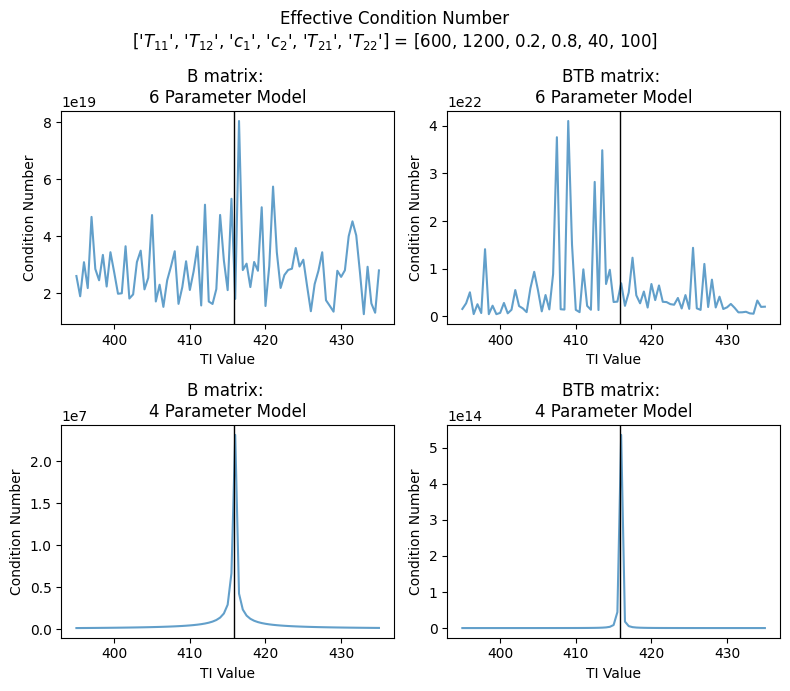

In [7]:
fig, ax = plt.subplots(2,2, figsize=(8,7), tight_layout=True)
fig.suptitle(f'Effective Condition Number\n{ParamTitle_6p} = [{T11}, {T12}, {c1}, {c2}, {T21}, {T22}]')

ax[0,0].plot(TI1_array, CN_6p_B, alpha = 0.7, label = 'B: 6p')
ax[0,1].plot(TI1_array, CN_6p_BTB, alpha = 0.7, label = 'BTB: 6p')
ax[1,0].plot(TI1_array, CN_4p_B, alpha = 0.7, label = 'B: 4p')
ax[1,1].plot(TI1_array, CN_4p_BTB, alpha = 0.7, label = 'BTB: 4p')

ax[0,0].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
ax[0,1].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
ax[1,0].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
ax[1,1].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')

ax[0,0].set_xlabel('TI Value')
ax[0,1].set_xlabel('TI Value')
ax[1,0].set_xlabel('TI Value')
ax[1,1].set_xlabel('TI Value')

ax[0,0].set_ylabel('Condition Number')
ax[0,1].set_ylabel('Condition Number')
ax[1,0].set_ylabel('Condition Number')
ax[1,1].set_ylabel('Condition Number')

ax[0,0].set_title('B matrix: \n6 Parameter Model')
ax[0,1].set_title('BTB matrix: \n6 Parameter Model')
ax[1,0].set_title('B matrix: \n4 Parameter Model')
ax[1,1].set_title('BTB matrix: \n4 Parameter Model')
plt.show()

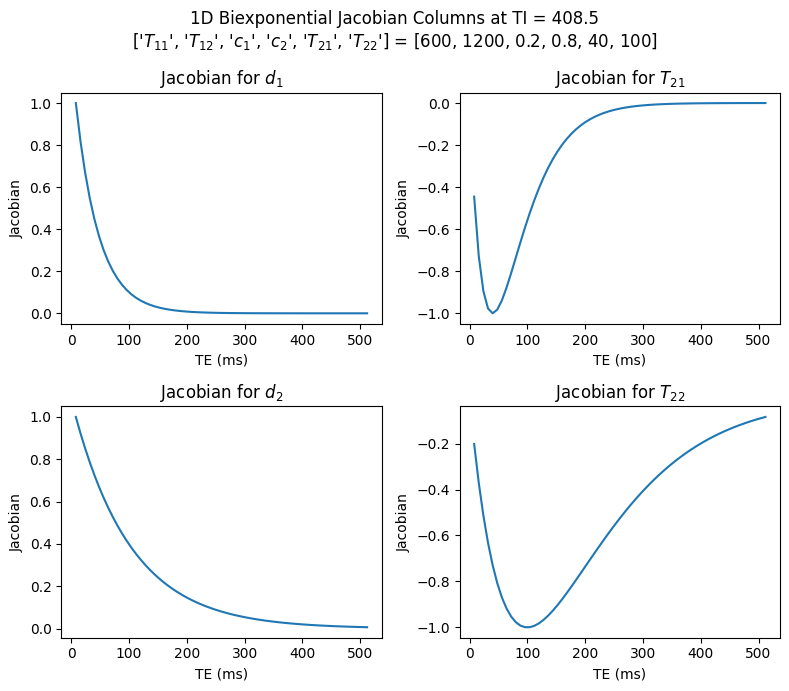

In [8]:
TI_temp = TI1_array[np.size(TI1_array)//3]

d1 = d_value(TI_temp,c1,T11)
d2 = d_value(TI_temp,c2,T12)


B_mat = Jacobian_4p(TE_series, d1, d2, T21, T22)
B_mat_colScale = B_mat/np.max(np.abs(B_mat),axis = 0)

fig, ax = plt.subplots(2,2, figsize=(8,7), tight_layout=True)
fig.suptitle(f'1D Biexponential Jacobian Columns at TI = {TI_temp}\n{ParamTitle_6p} = [{T11}, {T12}, {c1}, {c2}, {T21}, {T22}]')

for i in range(B_mat.shape[-1]):
    ax[i%2, i//2].plot(TE_series, B_mat_colScale[:,i])
    ax[i%2, i//2].set_title(f"Jacobian for {ParamTitle_4p[i]}")
    ax[i%2, i//2].set_xlabel("TE (ms)")
    ax[i%2, i//2].set_ylabel("Jacobian")

plt.show()

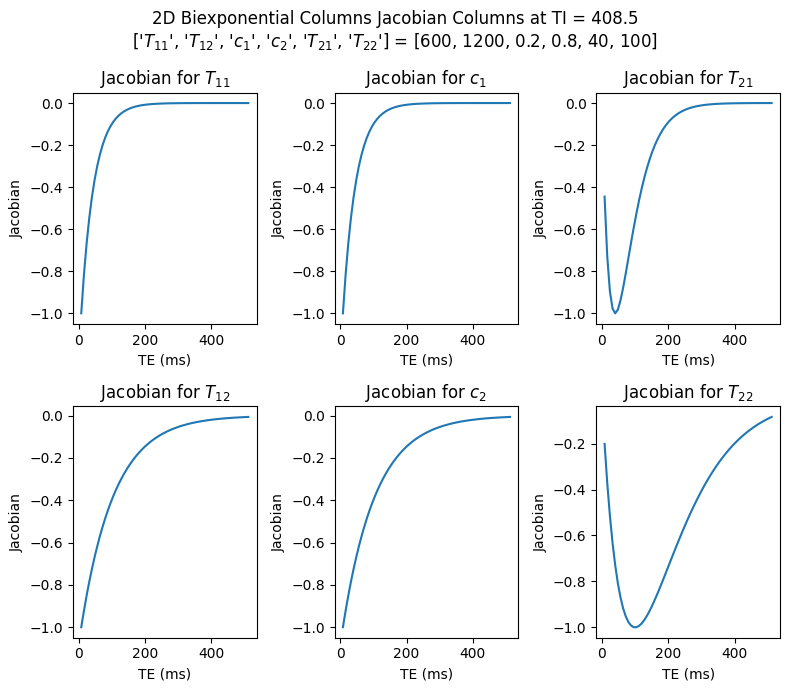

In [9]:
TI_temp = TI1_array[np.size(TI1_array)//3]

B_mat = Jacobian_6p(TE_series, TI_temp, T11, T12, c1, c2, T21, T22)
B_mat_colScale = B_mat/np.max(np.abs(B_mat),axis = 0)

fig, ax = plt.subplots(2,3, figsize=(8,7), tight_layout=True)
fig.suptitle(f'2D Biexponential Columns Jacobian Columns at TI = {TI_temp}\n{ParamTitle_6p} = [{T11}, {T12}, {c1}, {c2}, {T21}, {T22}]')

for i in range(B_mat.shape[-1]):
    ax[i%2, i//2].plot(TE_series, B_mat_colScale[:,i])
    ax[i%2, i//2].set_title(f"Jacobian for {ParamTitle_6p[i]}")
    ax[i%2, i//2].set_xlabel("TE (ms)")
    ax[i%2, i//2].set_ylabel("Jacobian")

plt.show()

In [10]:
CN_6p_BTB_cutC = np.zeros(np.size(TI1_array))
CN_6p_B_cutC = np.zeros(np.size(TI1_array))

CN_6p_BTB_cutT1 = np.zeros(np.size(TI1_array))
CN_6p_B_cutT1 = np.zeros(np.size(TI1_array))

for iTI in range(np.size(TI1_array)):

    TI_temp = TI1_array[iTI]

    if nondimensional_option:
        B_mat = Jacobian_6p(TE_series, TI_temp, T11, T12, c1, c2, T21, T22, TE_rescale = np.max(TE_series), TI_rescale = np.max(TI1_array))
    else:
        B_mat = Jacobian_6p(TE_series, TI_temp, T11, T12, c1, c2, T21, T22)

    CN_6p_BTB_cutC[iTI] = condition_num(B_mat[:,[0,1,4,5]])
    CN_6p_B_cutC[iTI] = np.linalg.cond(B_mat[:,[0,1,4,5]])

    CN_6p_BTB_cutT1[iTI] = condition_num(B_mat[:,2:])
    CN_6p_B_cutT1[iTI] = np.linalg.cond(B_mat[:,2:])

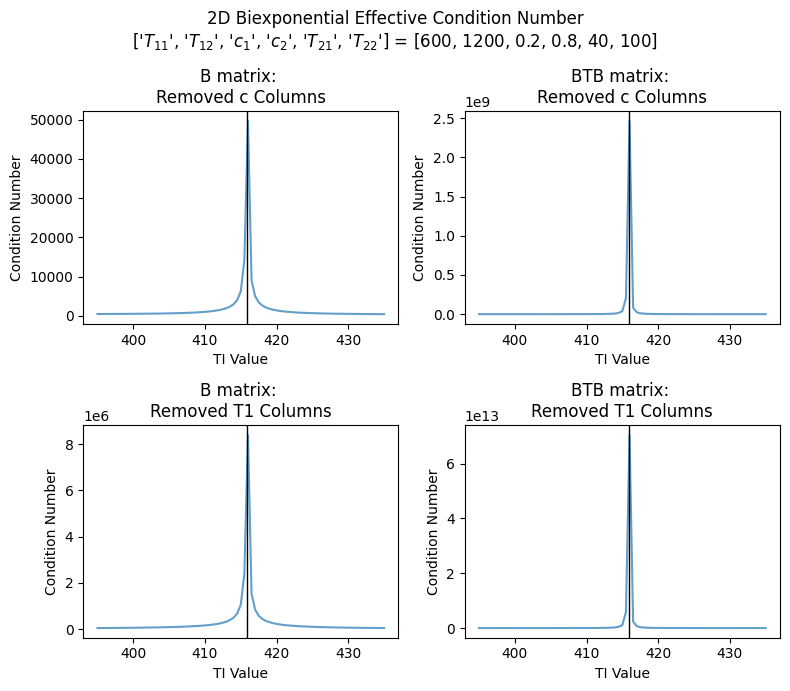

In [11]:
fig, ax = plt.subplots(2,2, figsize=(8,7), tight_layout=True)
fig.suptitle(f'2D Biexponential Effective Condition Number\n{ParamTitle_6p} = [{T11}, {T12}, {c1}, {c2}, {T21}, {T22}]')

ax[0,0].plot(TI1_array, CN_6p_B_cutC, alpha = 0.7, label = 'B: cut c')
ax[0,1].plot(TI1_array, CN_6p_BTB_cutC, alpha = 0.7, label = 'BTB: cut c')
ax[1,0].plot(TI1_array, CN_6p_B_cutT1, alpha = 0.7, label = 'B: cut T1')
ax[1,1].plot(TI1_array, CN_6p_BTB_cutT1, alpha = 0.7, label = 'BTB: cut T1')

ax[0,0].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
ax[0,1].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
ax[1,0].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
ax[1,1].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')

ax[0,0].set_xlabel('TI Value')
ax[0,1].set_xlabel('TI Value')
ax[1,0].set_xlabel('TI Value')
ax[1,1].set_xlabel('TI Value')

ax[0,0].set_ylabel('Condition Number')
ax[0,1].set_ylabel('Condition Number')
ax[1,0].set_ylabel('Condition Number')
ax[1,1].set_ylabel('Condition Number')

ax[0,0].set_title('B matrix: \nRemoved c Columns')
ax[0,1].set_title('BTB matrix: \nRemoved c Columns')
ax[1,0].set_title('B matrix: \nRemoved T1 Columns')
ax[1,1].set_title('BTB matrix: \nRemoved T1 Columns')
plt.show()